## Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load missing_indices from from the .npy file
missing_indices = np.load('../data/missing_indices.npy').tolist()

print("loaded omitted indices:", missing_indices)


loaded omitted indices: [2, 3, 4, 5, 9, 14, 18, 20, 22, 23]


### Code Attribution

Specific functions in this workbook are attributed to author Biswajit Sahoo, PhD. 

Dr. Sahoo's personal biography page is available at:
https://biswajitsahoo1111.github.io/

The project page of his open source material is available here:
https://biswajitsahoo1111.github.io/rul_codes_open/

Where indicated, specific functions were borrowed from this Jupyter workbook:
https://github.com/biswajitsahoo1111/rul_codes_open/blob/master/notebooks/cmapss_notebooks/CMAPSS_data_description_and_preprocessing.ipynb
<br>
<br>
<br>


{Sahoo_Data-Driven_Remaining_Useful_2020,
author = {Sahoo, Biswajit},
doi = {10.5281/zenodo.5890595},
month = {9},
title = {Data-Driven Remaining Useful Life (RUL) Prediction},
url = {https://biswajitsahoo1111.github.io/rul_codes_open/},
year = {2020}
}

#### Incorporating an Early RUL

We create the process_rul function because we also want to incorporate an early RUL, if specified. Early RUL is important because it allows for proactive maintenance decisions before a machine reaches its end of life, reducing the risk of unexpected failures and optimizing maintenance schedules. In many real world scenarios, repairs are conducted before complete failure. Therefore, the process_rul function is needed to generate RUL values that incorporate early warnings into the predictions. The early RUL provides an early warning that maintenance actions may be necessary before the machine fully reaches its end of life.

In [3]:
"""
The code for this function is attributed to author Bizwajit Sahoo.

https://biswajitsahoo1111.github.io/rul_codes_open/
"""

def process_targets(data_length, early_rul=None):
    
    # if no early RUL is provided, generate a descending sequence from data_length -1 to 0
    if early_rul is None:
        return np.arange(data_length - 1, -1, -1)
    
    else:
        # calculate the duration for which early RUL is applicable
        early_rul_duration = data_length - early_rul
        
        # if the early RUL duration is non-positive, use a linear degradation curve (same as when early_rul is none)
        if early_rul_duration <= 0:
            return np.arange(data_length - 1, -1, -1)
        
        else:
            # create an array where the first early_rul_duration values are equal to early_rul
            target_array = np.append(early_rul * np.ones(shape=(early_rul_duration,)),
                                     np.arange(early_rul - 1, -1, -1))  # Add descending values from early_rul-1 to 0
            return target_array


In the example below when the early RUL is five and data length is 10, the first five values of the RUL are all five. This indicates that for the first five time cycles, the engine/unit is expected to last atleast five or more cycles. Here, the machine is monitored closely, and early warnings suggest it can still operate reliably. After the first five cycles, the RUL starts decreasing. As the machine continues to be used, its RUL diminishes and we simulate the wear and tear. In real world, knowing that the engine has early RUL of five can allow maintenance teams to take action before it reaches critical failure, for instance, schedule maintenance check/repair/replace parts after fifth cycle. 

In [4]:
early_rul_none = process_targets(10, early_rul = None)
early_rul_five = process_targets(10, early_rul = 5)
early_rul_fifteen = process_targets(10, early_rul = 15)

print("Examples for data length = 10")
print()
print("Early RUL is None:")
print(early_rul_none)
print()  
print("Early RUL is five:")
print(early_rul_five)
print()  
print("Early RUL is fifteen:")
print(early_rul_fifteen)
print()  

Examples for data length = 10

Early RUL is None:
[9 8 7 6 5 4 3 2 1 0]

Early RUL is five:
[5. 5. 5. 5. 5. 4. 3. 2. 1. 0.]

Early RUL is fifteen:
[9 8 7 6 5 4 3 2 1 0]



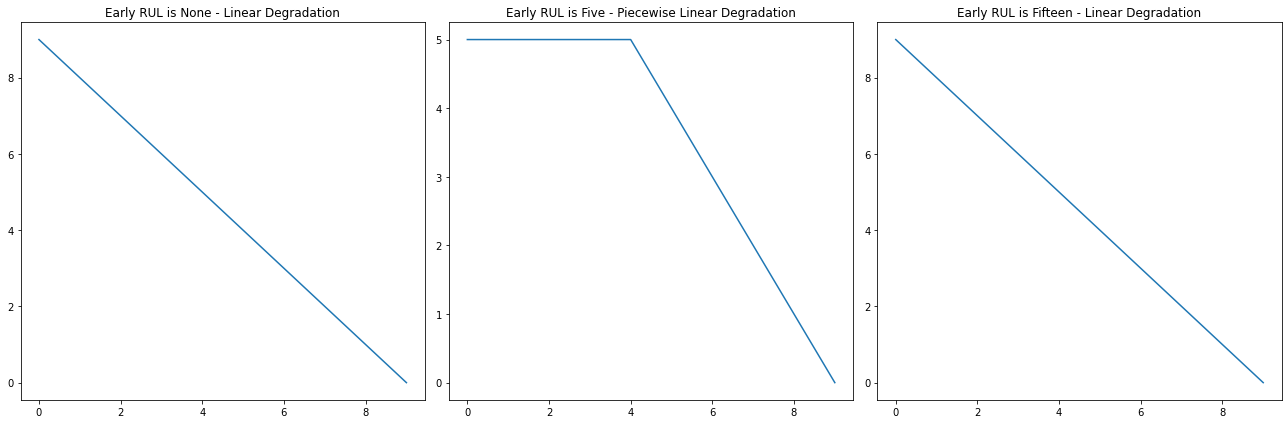

In [5]:
plt.figure(figsize=(18, 6))

plt.subplot(131) 
plt.plot(early_rul_none)
plt.title("Early RUL is None - Linear Degradation")

plt.subplot(132) 
plt.plot(early_rul_five)
plt.title("Early RUL is Five - Piecewise Linear Degradation")

plt.subplot(133) 
plt.plot(early_rul_fifteen)
plt.title("Early RUL is Fifteen - Linear Degradation")

plt.tight_layout() 
plt.show()

The pattern in the second image reflects real-world scenarios where machines may operate normally for a certain period (the early warning period) but then exhibit signs of wear that could lead to failure if not addressed. The constant early RUL allows for scheduled maintenance before reaching a critical point, helping to prevent unexpected repairs or safety events, in the case of jet engine failures.

### Function to Generate Batches Using Train/Test Data

The generate_data_batches_with_targets incorporates a window to the model in order to capture temporal patterns in the data. Each window will represent a fixed length sequence of data points which show the performance of the unit/engine over the specific period/window. The more recent the window, the more reflective it is of the future performance or failures. The window functionality will also allow us to analyze shorter segments of the unit/engine performance rather than the entire dataset at once. This level of granularity will allow the model to learn relevant features and trends because of the smaller windows we feed it, as opposed to being overwhelmed by excessive information and hence leadings to being unable to capture trends. 

In terms of the shifts incorporated using the function, the shifts allow for capturing overlapping windows which help to capture trends and changes more effectively. For instance, a shift of 1 means that each new window overlaps with the previous one by a single data point.
This overlap can help the model understand transitions in the data and improve its ability to make predictions based on recent changes. 

Finally, we are looking to create the batches because the batches are essential for efficient training of ML models. Instead of processing the entire dataset at once, which can be computationally expensive, we allow the processing of smaller batches which allow for quicker iterations. The training on batches will also help to sustain statistical stability. Each batch can provide a representative sample of the overall data distribution as opposed to forcing the model to memorize the entire dataset. 

The function also allows us to pair input windows with corresponding target values, if provided. The function prepares allows the model to learn to associate past data with future outcomes. For instance, if we have sensor X reading of 13.5, 13.3, 13.1 with RULs of 5, 4 and 3, then the model will pair sensor readings of 13.5, 13.3, 13.1 (assuming the window is 3 datapoints) with a final RUL of 3. Examples are provided below. 

In [6]:
# generate batches of data and targets from input_data and target_data based on specified window length and shift
# shift: no of steps to shift the window for the next batch
# window: length of each data window
# input data: all of our data from sensors, etc
# target data: RUL targers

"""
The code for this function is attributed to author Bizwajit Sahoo.

https://biswajitsahoo1111.github.io/rul_codes_open/
"""

def process_input_data_with_targets(input_data, target_data=None, window_length=1, shift=1):
    
    # calculate the number of batches (windows) to generate
    num_batches = int(np.floor((len(input_data) - window_length) / shift)) + 1
    num_features = input_data.shape[1]  # Number of features per sample
    
    # initialize an empty output array to hold the data batches, filled with NaN as a placeholder
    output_data = np.repeat(np.nan, repeats=num_batches * window_length * num_features).reshape(num_batches, window_length, num_features)

    # if no target data is provided, generate only the input data batches
    if target_data is None:
        for batch in range(num_batches):
            # calculate the start and end indices for the current window
            start_idx = shift * batch
            end_idx = start_idx + window_length
            output_data[batch, :, :] = input_data[start_idx:end_idx, :]
        return output_data
    
    # if target data is provided, initialize the output_targets array
    output_targets = np.repeat(np.nan, repeats=num_batches)
    
    for batch in range(num_batches):
        # calculate the start and end indices for the current window
        start_idx = shift * batch
        end_idx = start_idx + window_length
        output_data[batch, :, :] = input_data[start_idx:end_idx, :]
        
        # select the RUL value corresponding to the last element of the window
        output_targets[batch] = target_data[shift * batch + (window_length - 1)]
    
    return output_data, output_targets

In [7]:
# to test the above function 

# generate demo data which has 5 time steps and 2 features
input_data = np.random.rand(5, 2)

# generate demo RUL data
target_data = np.maximum(0, 5 - np.arange(5))

# convert to df
input_df = pd.DataFrame(input_data, columns=['feature_1', 'feature_2'])
target_df = pd.Series(target_data, name='RUL')

# specify window length and shift 
window_length = 3
shift = 2

# apply the function 
output_data, output_targets = process_input_data_with_targets(input_data, target_data, window_length, shift)
print("input data")
print(input_df)
print()
print("output data")
print(output_data)
print()
print("target data")
print(target_data)
print("output targets")
print(output_targets)

input data
   feature_1  feature_2
0   0.124310   0.275398
1   0.736158   0.556469
2   0.331620   0.164734
3   0.690437   0.422510
4   0.789145   0.451767

output data
[[[0.12430993 0.27539817]
  [0.73615842 0.55646927]
  [0.33161967 0.16473392]]

 [[0.33161967 0.16473392]
  [0.69043702 0.42251024]
  [0.78914463 0.45176673]]]

target data
[5 4 3 2 1]
output targets
[3. 1.]


### Function to Generate Batches Using Test Data with Most Recent Data

In [8]:
# this function is very similar to generate batches function, however, if there are not enough batches to meet num_test_windows, 
# it adjusts the number of batches to the maximum possible and calculates the required length of data accordingly
# if sufficient batches are available, it calculates the required length based on num_test_windows.
# in summary: it prepares test data by creating batches from the end of the dataset

"""
The code for this function is attributed to author Bizwajit Sahoo.

https://biswajitsahoo1111.github.io/rul_codes_open/
"""

def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows=1):
    
    # calculate the maximum number of complete batches (windows) that can be created from the test data for this engine
    max_num_test_batches = int(np.floor((len(test_data_for_an_engine) - window_length) / shift)) + 1
    
    # check if the requested number of test windows can be extracted
    if max_num_test_batches < num_test_windows:
        # if there are not enough batches, adjust to the maximum possible
        required_len = (max_num_test_batches - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(
            test_data_for_an_engine[-required_len:, :],  # extract the most recent `required_len` data points
            target_data=None,                           # no target data for test processing
            window_length=window_length, 
            shift=shift)
        
        # set the actual number of test windows extracted
        extracted_num_test_windows = max_num_test_batches
    else:
        # if enough batches are available, extract the requested number of windows
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(
            test_data_for_an_engine[-required_len:, :],  # extract the most recent `required_len` data points
            target_data=None,                           # no target data for test processing
            window_length=window_length, 
            shift=shift)
        
        # set the number of test windows to the requested value
        extracted_num_test_windows = num_test_windows
    
    # return the batched data and the actual number of windows extracted
    return batched_test_data_for_an_engine, extracted_num_test_windows



In [9]:
# to test the above function

# demo 2D array with 10 samples and 2 features
test_data = np.reshape(np.arange(15), newshape = (5,3))

# define params
window_length = 2    # length of each batch
shift = 1            # step size of window
num_test_windows = 3 # no of test samples to extract

# call process
batched_test_data, extracted_num_test_windows = process_test_data(test_data, window_length, shift, num_test_windows)

print("test data")
print(test_data)
print()
print("batched test data:")
print(batched_test_data)
print()
print("extracted num of test windows:")
print(extracted_num_test_windows)

test data
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]

batched test data:
[[[ 3.  4.  5.]
  [ 6.  7.  8.]]

 [[ 6.  7.  8.]
  [ 9. 10. 11.]]

 [[ 9. 10. 11.]
  [12. 13. 14.]]]

extracted num of test windows:
3


### Define Additional Functions to Finalize Data Preprocessing

In [10]:
from sklearn.preprocessing import StandardScaler

WINDOW_LENGTH = 30  # the length of the sliding window for batch creation
SHIFT = 1           # the shift between two consecutive windows (affects overlap)
EARLY_RUL = 125     # the early Remaining Useful Life (RUL) threshold for target generation
NUM_TEST_WINDOWS = 1  # number of test windows to extract from the most recent data
COLUMNS_TO_DROP = [0, 1] + missing_indices

"""
The code for these functions is attributed to author Bizwajit Sahoo.

https://biswajitsahoo1111.github.io/rul_codes_open/
"""

# this function scales the training and test data using standardscaler, ensuring that the data has a mean of 0 and standard deviation of 1.

def scale_data(train_data, test_data, columns_to_drop):

    # extract the first column (engine identifier) to reattach later after scaling
    train_data_first_column = train_data[0]
    test_data_first_column = test_data[0]

    # initialize the scaler
    scaler = StandardScaler()

    # scale all columns except those specified in `columns_to_drop`
    # the `drop()` function removes the columns that we don't want to scale
    train_data_scaled = scaler.fit_transform(train_data.drop(columns=columns_to_drop))
    test_data_scaled = scaler.transform(test_data.drop(columns=columns_to_drop))  # only use `transform` for test data

    # re-attach the engine identifier column to the scaled data
    train_data_scaled = pd.DataFrame(np.c_[train_data_first_column, train_data_scaled])
    test_data_scaled = pd.DataFrame(np.c_[test_data_first_column, test_data_scaled])

    return train_data_scaled, test_data_scaled


# this function processes the training data for each engine and creates data batches with corresponding rul targets. 
# it also checks if each engine has enough data to form the required windows.

def process_train_data(train_data, window_length, shift, early_rul):

    processed_train_data = []  # list to hold all the processed data batches
    processed_train_targets = []  # list to hold all the corresponding rul targets

    # get the number of unique engines in the dataset
    num_train_machines = len(train_data[0].unique())  # assuming engine id is in the first column

    # iterate through each engine and process its data
    for engine_id in range(1, num_train_machines + 1):
        # filter data for the current engine by its id (drop the engine id column)
        engine_data = train_data[train_data[0] == engine_id].drop(columns=[0]).values  # convert to numpy array

        # ensure the engine has enough data for the specified window length
        if len(engine_data) < window_length:
            raise ValueError(f"engine {engine_id} does not have enough data for window length {window_length}")
        
        # generate the rul target values for the current engine
        targets = process_targets(data_length=len(engine_data), early_rul=early_rul)

        # generate the batches of data and their corresponding target rul values
        data_batches, target_batches = process_input_data_with_targets(
            engine_data, targets, window_length=window_length, shift=shift
        )

        # append the processed data and targets for the current engine to the respective lists
        processed_train_data.append(data_batches)
        processed_train_targets.append(target_batches)

    # concatenate the data and targets from all engines into single arrays
    return np.concatenate(processed_train_data), np.concatenate(processed_train_targets)

# this function processes the test data for each engine and creates data windows. it also handles the number of test windows 
# that should be extracted from each engine's data.

def process_test_data_for_engines(test_data, window_length, shift, num_test_windows):
    
    processed_test_data = []  # list to hold all the processed test data batches
    num_test_windows_list = []  # list to hold the number of test windows for each engine

    # get the number of unique engines in the test dataset
    num_test_machines = len(test_data[0].unique())  # assuming engine id is in the first column

    # iterate through each engine and process its test data
    for engine_id in range(1, num_test_machines + 1):
        # filter data for the current engine by its id (drop the engine id column)
        engine_data = test_data[test_data[0] == engine_id].drop(columns=[0]).values  # convert to numpy array
        
        # ensure the engine has enough data for the specified window length
        if len(engine_data) < window_length:
            raise ValueError(f"engine {engine_id} does not have enough data for window length {window_length}")

        # prepare the test data windows and determine the number of test windows to extract
        test_data_batches, num_windows = process_test_data(
            engine_data, window_length=window_length, shift=shift, num_test_windows=num_test_windows
        )

        # append the processed test data and the number of test windows for this engine
        processed_test_data.append(test_data_batches)
        num_test_windows_list.append(num_windows)

    # concatenate the data from all test engines into a single array
    return np.concatenate(processed_test_data), num_test_windows_list


# this is the main pipeline that reads the raw data, scales it, processes it into windows, and prepares it for model training and testing. 
# it processes both the training and test data, along with their corresponding targets.

def process_data(train_file, test_file, rul_file, window_length, shift, early_rul, num_test_windows, columns_to_drop):

    # load the raw data from the provided csv files
    train_data = pd.read_csv(train_file, sep="\s+", header=None)
    test_data = pd.read_csv(test_file, sep="\s+", header=None)
    true_rul = pd.read_csv(rul_file, sep="\s+", header=None)

    # scale the training and test data
    train_data, test_data = scale_data(train_data, test_data, columns_to_drop)

    # process the training data into windows and targets
    processed_train_data, processed_train_targets = process_train_data(
        train_data, window_length, shift, early_rul
    )

    # process the test data into windows
    processed_test_data, num_test_windows_list = process_test_data_for_engines(
        test_data, window_length, shift, num_test_windows
    )

    # shuffle the training data to avoid any bias during training
    shuffle_index = np.random.permutation(len(processed_train_targets))
    processed_train_data, processed_train_targets = processed_train_data[shuffle_index], processed_train_targets[shuffle_index]

    # true rul values for test set
    true_rul = true_rul[0].values  # convert to numpy array

    return (processed_train_data, processed_train_targets, processed_test_data, 
            true_rul, num_test_windows_list)


What does shuffling really do? 

In [11]:
# shuffling function so we can significantly improve the robustness and reliability of the model's training process
# without shuffling, the model may learn to recognize patterns that are only valid in the specific sequnence rather than capturing broader relationships
# especially when batching, shuffling ensures that each batch contains a mix of examples and helps maintain the statisitcal proporties of the df

def shuffle_training_data(train_data, train_targets):
    shuffled_indices = np.random.permutation(len(train_targets))
    return train_data[shuffled_indices], train_targets[shuffled_indices]

In [12]:
# to demo the code above

# create demo data
train_data = np.reshape(np.arange(15), newshape = (5, 3))

# corresponding target generation
train_targets = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

print("original train data:")
print(train_data)
print("original targets:")
print(train_targets)

# shuffle the training data and targets
shuffled_train_data, shuffled_train_targets = shuffle_training_data(train_data, train_targets)

print("\nShuffled Training Data:")
print(shuffled_train_data)
print("Shuffled Targets:")
print(shuffled_train_targets)


original train data:
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]]
original targets:
[0.1 0.2 0.3 0.4 0.5]

Shuffled Training Data:
[[ 6  7  8]
 [ 3  4  5]
 [ 9 10 11]
 [ 0  1  2]
 [12 13 14]]
Shuffled Targets:
[0.3 0.2 0.4 0.1 0.5]


#### Preprocess the Train and Test Data

In [13]:
# paths to the data
train_file = "../data/CMAPSSData/train_FD001.txt"
test_file = "../data/CMAPSSData/test_FD001.txt"
rul_file = "../data/CMAPSSData/RUL_FD001.txt"

# process the data
processed_train_data, processed_train_targets, processed_test_data, true_rul, num_test_windows_list = process_data(
    train_file, test_file, rul_file, window_length=WINDOW_LENGTH, shift=SHIFT, early_rul=EARLY_RUL, 
    num_test_windows=NUM_TEST_WINDOWS, columns_to_drop=COLUMNS_TO_DROP)

# ouput
print("Processed training data shape:", processed_train_data.shape)
print("Processed training targets shape:", processed_train_targets.shape)
print("Processed test data shape:", processed_test_data.shape)
print("True RUL shape:", true_rul.shape)

Processed training data shape: (17731, 30, 14)
Processed training targets shape: (17731,)
Processed test data shape: (100, 30, 14)
True RUL shape: (100,)


The code below prepared scaled, un-smoothed, and un-batched data for use in the TTM. 

WARNING! The test data is fit to itself rather than to the train data - not fit for use in the traditional machine learning models!.

In [14]:
train_data = pd.read_csv(train_file, sep="\s+", header=None)
test_data = pd.read_csv(test_file, sep="\s+", header=None)
true_rul = pd.read_csv(rul_file, sep="\s+", header=None)

train_data_scaled = scale_data(train_data, test_data, COLUMNS_TO_DROP)[0]

print("SHOWING SCALED TRAIN DATA, UNBATCHED: ")
display(train_data_scaled[0:3])

print("\n", "SHOWING SCALED TEST DATA, UNBATCHED: ")
tst = test_data.copy()
tst_col1 = tst.iloc[:,0]
tst.drop(columns = COLUMNS_TO_DROP[1:], inplace = True)
tst = pd.DataFrame(StandardScaler().fit_transform(tst))
tst.iloc[:, 0] = tst_col1
test_data_scaled = tst.copy()
display(test_data_scaled[0:3])

del tst, test_data, train_data

SHOWING SCALED TRAIN DATA, UNBATCHED: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,-1.721725,-0.134255,-0.925936,0.141683,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.603816,-0.781710,1.348493,1.194427
1,1.0,-1.061780,0.211528,-0.643726,0.141683,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.275852,-0.781710,1.016528,1.236922
2,1.0,-0.661813,-0.413166,-0.525953,0.141683,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.649144,-2.073094,0.739891,0.503423



 SHOWING SCALED TEST DATA, UNBATCHED: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.0,1.359276,-0.561495,-0.975674,0.17566,0.209138,-0.539078,-0.720312,-1.103591,-0.049542,-0.720590,-0.711659,-0.463406,-0.229408,0.448866
1,1.0,-1.908502,0.070116,-1.392836,0.17566,1.603612,-1.061366,-0.348673,0.427727,0.736727,-0.193647,-1.570037,0.347276,0.899934,0.664042
2,1.0,-0.037636,-0.231698,-0.507676,0.17566,0.517390,-0.364982,-0.126564,0.427727,0.397202,-0.720590,0.629340,0.347276,1.323438,0.961247


### Saving the Data

In [15]:
import os
import pickle

# create a new directory for processed data
output_dir = '../data/processed_data_pickle_files_no_smoothing'
os.makedirs(output_dir, exist_ok=True)  # creates the directory if it doesn't exist

# save processed data  directory
with open(os.path.join(output_dir, 'train_data_batches.pkl'), 'wb') as f:
    pickle.dump(processed_train_data, f)

with open(os.path.join(output_dir, 'train_target_values.pkl'), 'wb') as f:
    pickle.dump(processed_train_targets, f)

with open(os.path.join(output_dir, 'test_data_batches.pkl'), 'wb') as f:
    pickle.dump(processed_test_data, f)

with open(os.path.join(output_dir, 'true_rul_values.pkl'), 'wb') as f:
    pickle.dump(true_rul, f)

#Unbatched data is saved below (for use in the TTM).    
with open(os.path.join(output_dir, 'train_data_no_batches.pkl'), 'wb') as f:
    pickle.dump(train_data_scaled, f)

with open(os.path.join(output_dir, 'test_data_no_batches.pkl'), 'wb') as f:
    pickle.dump(test_data_scaled, f)